# Progetto Applicazioni Data Intensive 2023
## Riconoscimento di un'anomalia

#### Autori: Alessandro Sciarrillo e Niccolò Mussoni

In [13]:
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

NOTE

- dati che si discostano troppo da q3 + 3*iqr dove iqr = q3-q1
- anomalie prolungate considerate come failure -> valutare contare consecutive in api
- mostrare valori dei sensori durante le anomalie

## Contesto e Obbiettivo del modello
(Linee guida: Descrivere in modo chiaro il contesto e l’obiettivo del modello di predizione, la fonte e la struttura del
dataset utilizzato e le variabili che contiene. Eseguire eventualmente una prima scrematura dei dati,
eliminando ad es. variabili palesemente non informative (es. identificatori) o con molti dati nulli.)

## Obiettivo
// TODO

## Dataset
Il dataset (1) raccoglie le misurazioni effettuate dall'APU di un treno nella metro di Porto. Ci concentriamo su una serie di sensori analogici e digitali installati sul treno. 
Le misurazioni dei sensori sono state raccolte da Febbraio a Settembre 2020, con un intervallo temporale di 10 secondi tra loro, dove i 15 segnali sono raccolti da un dispositivo embedded a bordo che è capace di trasferire i dati al server usando il protocollo TCP/IP.

(1): https://archive.ics.uci.edu/dataset/791/metropt+3+dataset

In [14]:
file_zip_url = "https://archive.ics.uci.edu/static/public/791/metropt+3+dataset.zip"
file_zip_name = "metropt+3+dataset.zip"
file_data_set_name = "MetroPT3(AirCompressor).csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

# specifichiamo tipi di dato per ottimizzare lo spazio occupato
types = {
    "COMP": np.uint8, 
    "DV_eletric": np.uint8,
    "Towers": np.uint8, 
    "MPG": np.uint8,
    "LPS": np.uint8,
    "Pressure_switch": np.uint8, 
    "Oil_level": np.uint8, 
    "Caudal_impulses": np.uint8
}
        
dataset_full = pd.read_csv(file_data_set_name, sep=",", dtype=types, parse_dates=["timestamp"])

#dataset_full = pd.read_csv("MetroPT3(AirCompressor).csv", sep=",", dtype=types, parse_dates=["timestamp"])
#dataset_full = pd.read_csv("../../Downloads/MetroPT3(AirCompressor).csv", sep=",", dtype=types, parse_dates=["timestamp"])
dataset_full.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


### Prima fase di pulizia dei dati
Rimuoviamo la prima colonna, in quanto contiene degli identificatori non informativi per il nostro scopo e impostiamo il timestamp come indice.

In [126]:
dataset = dataset_full.drop(dataset_full.columns[[0]], axis=1)
dataset.set_index(["timestamp"],  inplace=True)
dataset.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1,0,1,1,0,1,1,1
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1,0,1,1,0,1,1,1
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1,0,1,1,0,1,1,1


## Variabili
### Valori analogici
- **`TP2`**: pressione del compressore [bar]
- **`TP3`**: pressione generata nel pannello pneumatico [bar]
- **`H1`**: pressione generata a causa di un calo di pressione quando avviene una scarica del filtro separatore ciclonico [bar]
- **`DV_pressure`**: misura del calo di pressione generato quando le torri scaricano gli essiccatori d'aria [bar]
- **`Reservoirs`**: pressione sul fondo dei serbatoi [bar]
- **`Motor_Current`**: corrente di una fase del motore trifase [A] 
    - 0A - spento 
    - 4A - assenza di carico
    - 7A - sotto carico 
    - 9A - in funzione
- **`Oil_Temperature`**: temperatura dell'olio nel compressore [°C]

### Valori digitali
- **`COMP`**: segnale della valvola di aspirazione dell'aria nel compressore
    - acceso quando non viene aspirata aria, indicando che il compressore è spento o sta lavorando in assenza di carico
- **`DV_eletric`**: segnale che controlla la valvola di scarico del compressore 
    - spento se il compressore è spento o sta lavorando in assenza di carico
- **`TOWERS`**: segnale che indica quale torre responsabile dell'umidità dell'aria sta lavorando
    - se spento sta lavorando la prima torre, quella responsabile dell'essicatura dell'aria 
    - se acceso sta lavorando la seconda torre, quella responsabile del rilascio dell'umidità rimossa dall'aria
- **`MPG`**: segnale che accende il compressore sotto carico attivando la valvola di aspirazione quando la pressione nell'APU scende sotto 8.2 bar. Attiva il sensore COMP, che ha lo stesso comportamento
- **`LPS`**: segnale che si accende quando la pressione scende sotto 7 bar
- **`Pressure Switch`**: segnale che rileva la fase di scarico nelle torri di essicazione
- **`Oil_Level`**: segnale che rileva il livello dell'olio nel compressore
    - acceso quando il livello dell'olio è sotto i valori attesi
- **`Caudal_Impulse`**: segnale che conta gli impulsi generati dall'aria che va dall'APU ai serbatoi.

### Integrazione con periodi di anomalia verificati
Dal paper (2) che ha raccolto questi dati abbiamo ricavato gli intervalli di data-ora in cui un esperto ha determinato se ci fossero state anomalie nell'APU, comprese nel periodo da Aprile a Luglio 2020

(2): https://ieeexplore.ieee.org/document/9564181

In [136]:
def set_anomaly(anomaly_dates):
    dataset["anomaly"] = 0
    for s, e in anomaly_dates:
        start = [int(st) for st in s.split(',')]
        end = [int(en) for en in e.split(',')]
        mask = (dataset.index >= datetime.datetime(*start)) & (dataset.index <= datetime.datetime(*end))
        dataset["anomaly"][mask] = 1 
        
anomaly_dates = [
    ('2020,4,12,11,50,0', '2020,4,12,23,30,0'),
    ('2020,4,18,0,0,0', '2020,4,18,23,59,0'),
    ('2020,4,19,0,0,0', '2020,4,19,1,30,0'),
    ('2020,4,29,3,20,0', '2020,4,29,4,0,0'),
    ('2020,4,29,22,0,0', '2020,4,29,22,20,0'),
    ('2020,5,13,14,0,0', '2020,5,13,23,59,0'),
    ('2020,5,18,5,0,0', '2020,5,18,5,30,0'),
    ('2020,5,19,10,10,0', '2020,5,19,11,0,0'),
    ('2020,5,19,22,10,0', '2020,5,19,23,59,0'),
    ('2020,5,20,0,0,0', '2020,5,20,20,0,0'),
    ('2020,5,23,9,50,0', '2020,5,23,10,10,0'),
    ('2020,5,29,23,30,0', '2020,5,29,23,59,0'),
    ('2020,5,30,0,0,0', '2020,5,30,6,0,0'),
    ('2020,6,1,15,0,0', '2020,6,1,15,40,0'),
    ('2020,6,3,10,0,0', '2020,6,3,11,0,0'),
    ('2020,6,5,10,0,0', '2020,6,5,23,59,0'),
    ('2020,6,6,0,0,0', '2020,6,6,23,59,0'),
    ('2020,6,7,0,0,0', '2020,6,7,14,30,0'),
    ('2020,7,8,17,30,0', '2020,7,8,19,0,0'),
    ('2020,7,15,14,30,0', '2020,7,15,19,0,0'),
    ('2020,7,17,4,30,0', '2020,7,17,5,30,0'),
]

set_anomaly(anomaly_dates)

mask = (dataset.index > datetime.datetime(2020, 4, 12, 11, 49, 0)) & (dataset.index <= datetime.datetime(2020, 4, 12, 11, 51, 0))
dataset[mask].loc[:, "anomaly":]

C:\Users\nicco\AppData\Local\Temp\ipykernel_13288\2617755345.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["anomaly"][mask] = 1


,anomaly
timestamp,
2020-04-12 11:49:02,0
2020-04-12 11:49:12,0
2020-04-12 11:49:22,0
2020-04-12 11:49:32,0
2020-04-12 11:49:42,0
2020-04-12 11:49:51,0
2020-04-12 11:50:01,1
2020-04-12 11:50:11,1
2020-04-12 11:50:21,1


## Analisi Esplorativa
(Linee guida: Eseguire un’analisi esplorativa del dataset, riportando statistiche generali (medie, quartili, valori distinti,
indici di correlazione, …) e distribuzioni delle variabili in tabelle e grafici (a torta, istogrammi, a dispersione,
…). Commentare adeguatamente i risultati dell’analisi ed utilizzarli eventualmente per eliminare dati non
utilizzabili nell’analisi.)

In [139]:
dataset.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,anomaly
count,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000,1516948.000
mean,1.368,8.985,7.568,0.056,8.985,62.644,2.050,0.837,0.161,0.920,0.833,0.003,0.991,0.904,0.937,0.032
std,3.251,0.639,3.333,0.382,0.638,6.516,2.302,0.369,0.367,0.272,0.373,0.058,0.092,0.294,0.243,0.176
min,-0.032,0.730,-0.036,-0.032,0.712,15.400,0.020,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.014,8.492,8.254,-0.022,8.494,57.775,0.040,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
50%,-0.012,8.960,8.784,-0.020,8.960,62.700,0.045,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
75%,-0.010,9.492,9.374,-0.018,9.492,67.250,3.808,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0.000
max,10.676,10.302,10.288,9.844,10.300,89.050,9.295,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Circa il 3% del dataset contiene delle anomalie, ma essendo state valutate in un periodo più ristretto rispetto al dataset intero, consideriamo i dati relativi solo a quel periodo (Aprile-Luglio 2020)

In [143]:
mask = (dataset.index.date >= datetime.date(2020, 4, 1)) & (dataset.index.date < datetime.date(2020, 8, 1))
dataset = dataset[mask]

dataset.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,anomaly
timestamp,,,,,,,,,,,,,,,,
2020-04-01 00:00:09,-0.014,8.594,8.582,-0.024,8.598,59.000,0.0450,1,0,1,1,0,1,1,1,0
2020-04-01 00:00:18,-0.014,8.580,8.568,-0.024,8.584,58.950,0.0425,1,0,1,1,0,1,1,1,0
2020-04-01 00:00:28,-0.014,8.566,8.554,-0.024,8.570,58.800,0.0425,1,0,1,1,0,1,1,1,0
2020-04-01 00:00:38,-0.014,8.552,8.540,-0.022,8.556,58.700,0.0425,1,0,1,1,0,1,1,1,0
2020-04-01 00:00:48,-0.014,8.536,8.526,-0.024,8.540,58.575,0.0425,1,0,1,1,0,1,1,1,0


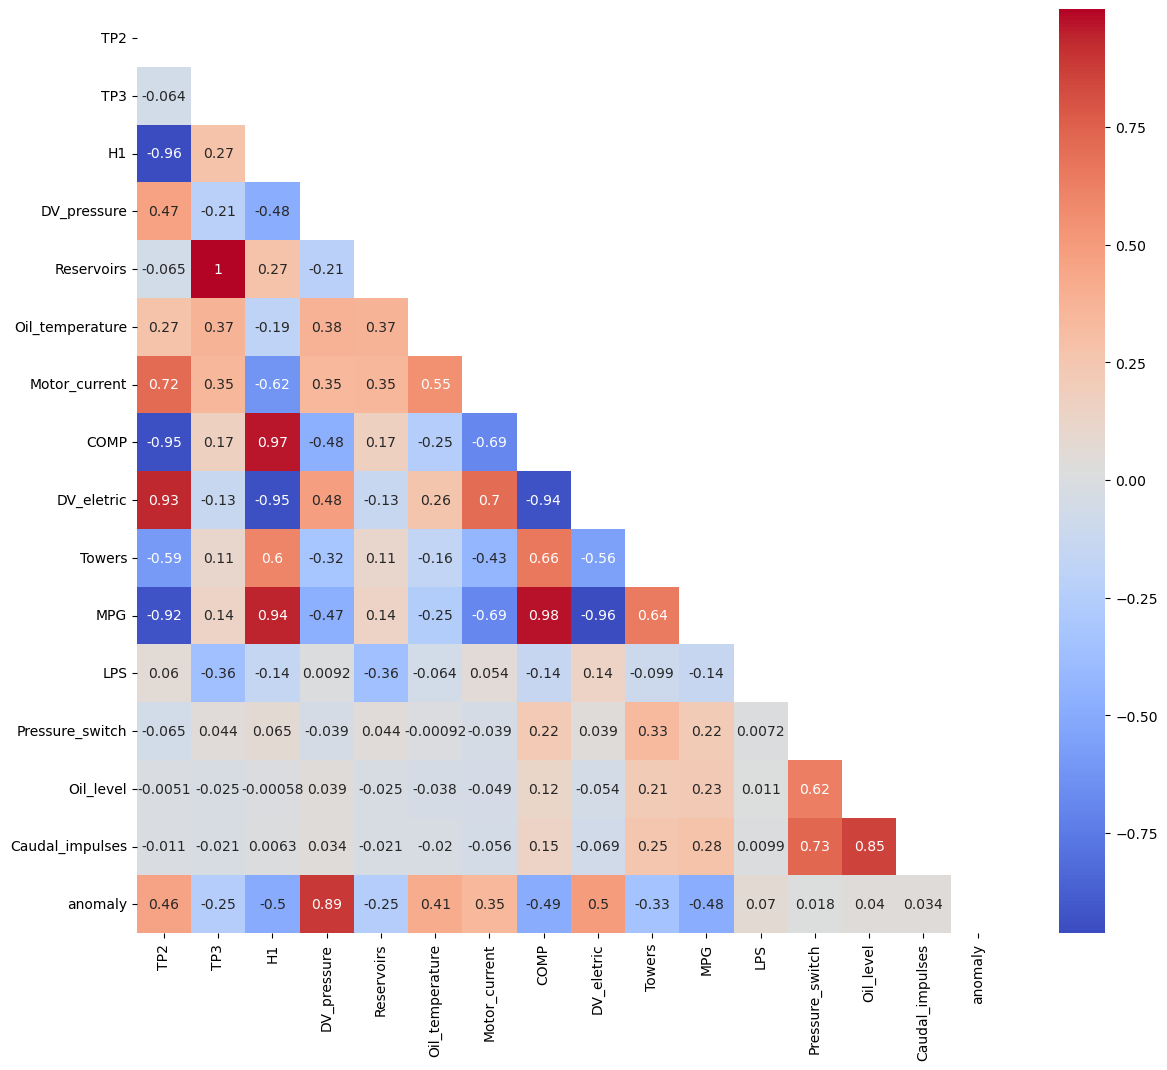

In [162]:
import seaborn as sns

corr_df = dataset.corr(method='pearson')
mask_tr = np.triu(corr_df)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_df, annot=True, mask=mask_tr, cmap='coolwarm')
plt.show()

Sicuramente le osservazioni principali da fare riguardano l'anomalia, che ha una correlazione positiva soprattutto con gli attributi TP2, DV_pressure, Oil_temperature, Motor_current, DV_eletric, mentre c'è una correlazione negativa con H1, COMP e MPG.

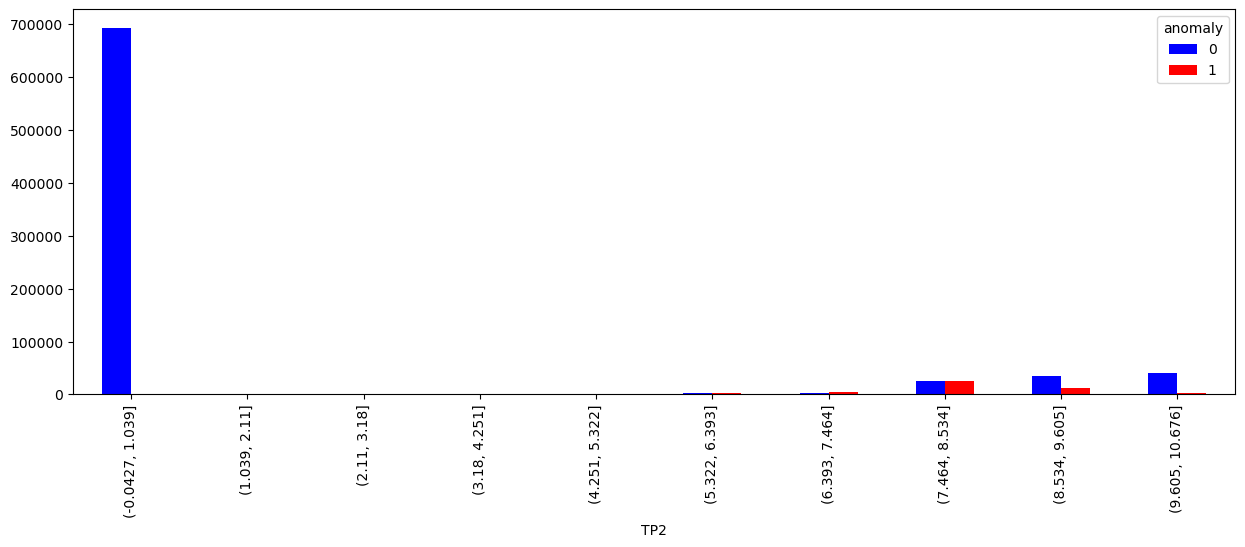

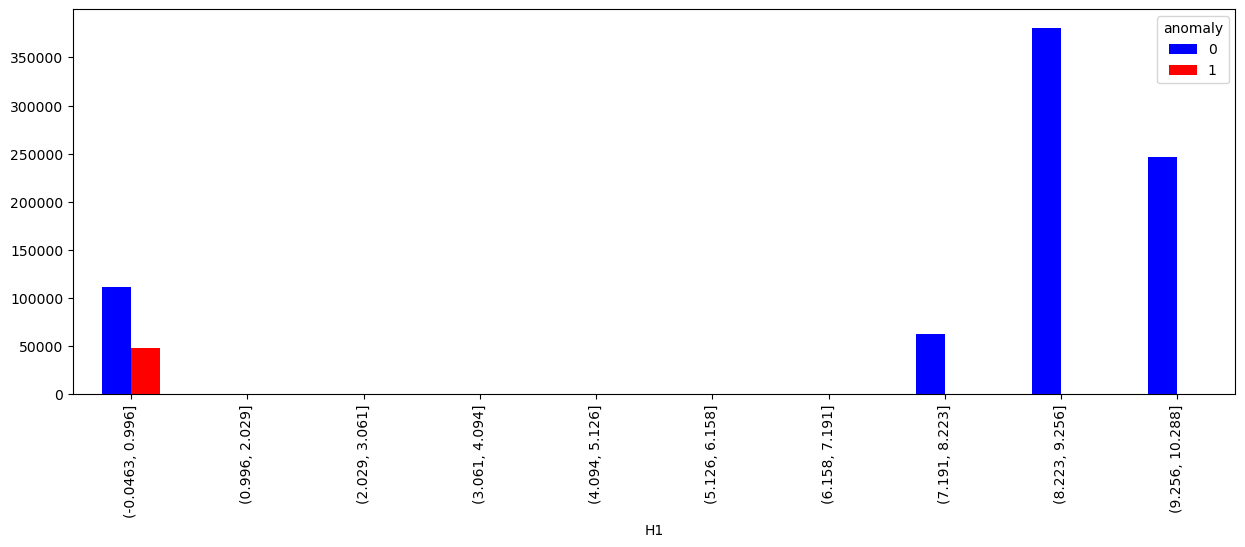

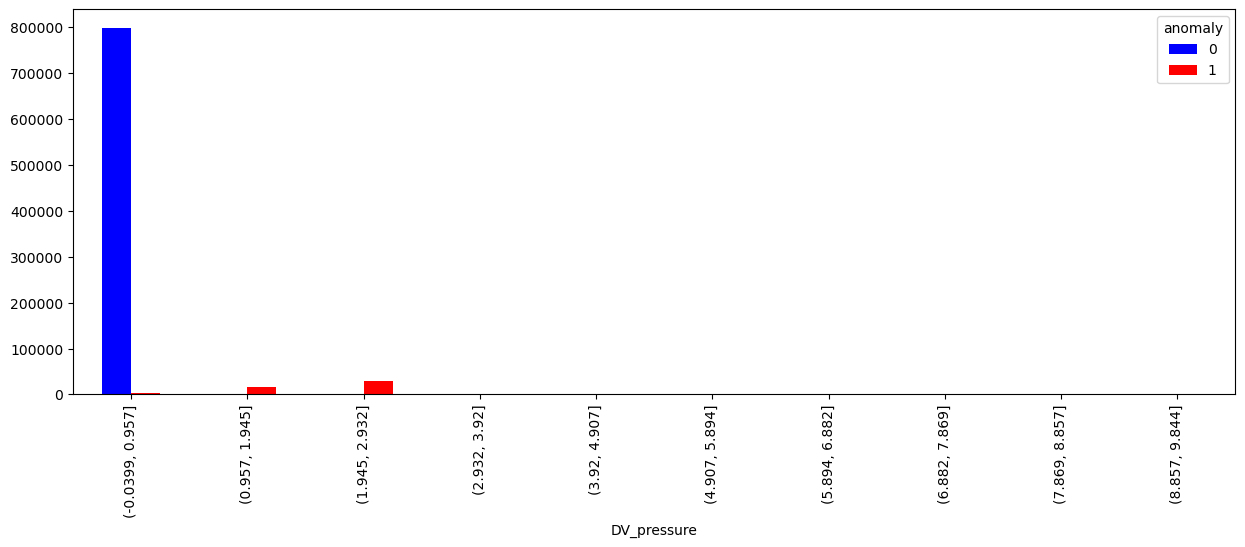

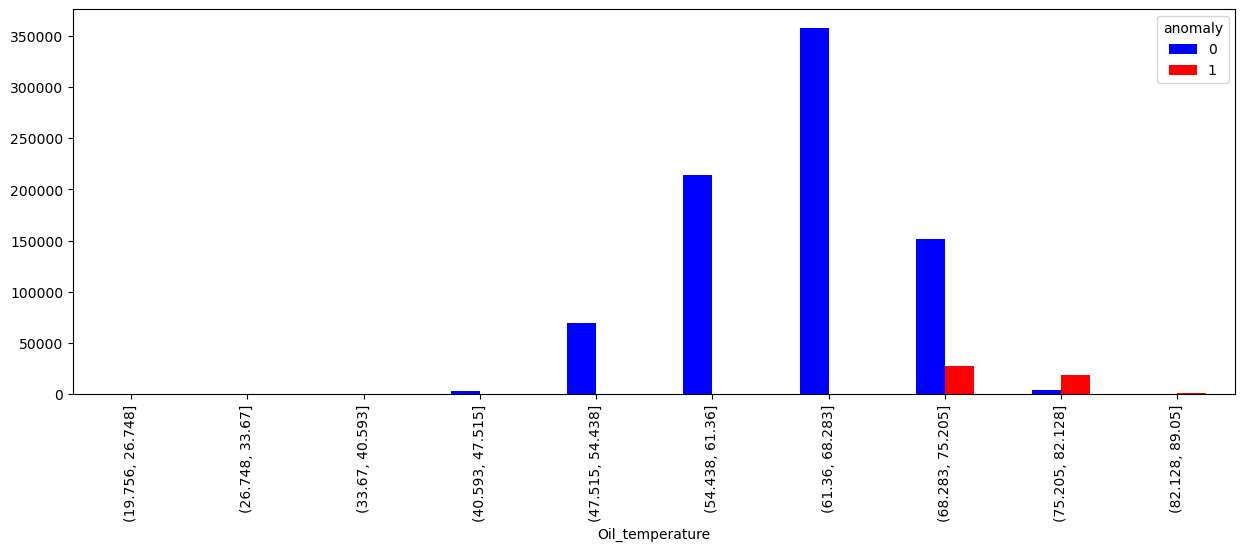

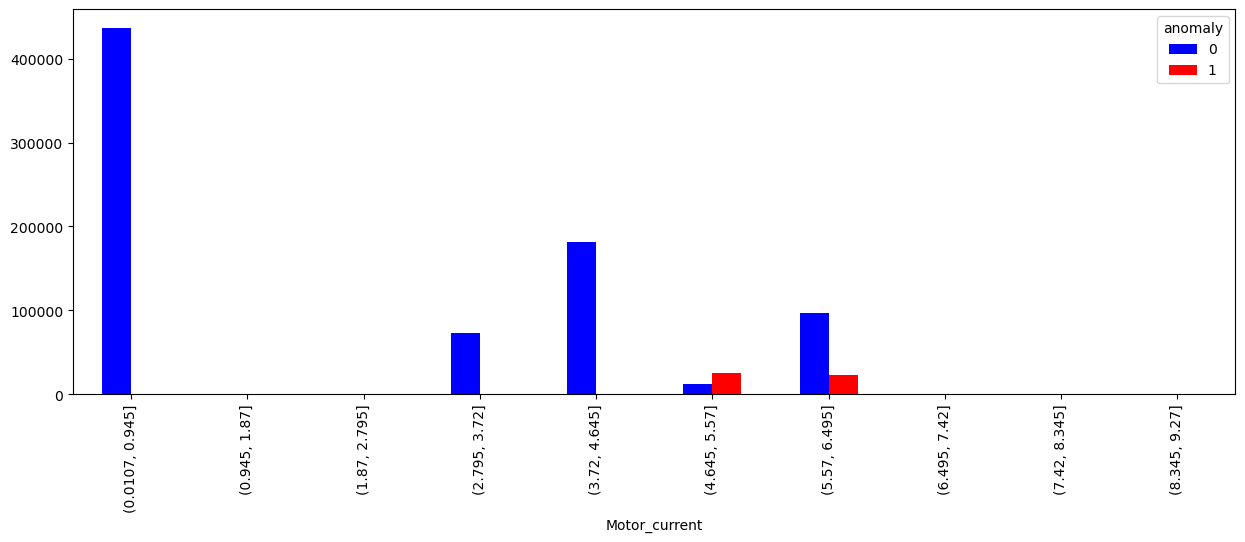

In [202]:
is_anomaly = dataset["anomaly"] == 1
~is_anomaly

analog = ["TP2", "H1", "DV_pressure", "Oil_temperature", "Motor_current"]

for col in analog:
    _ = dataset.groupby([pd.cut(dataset[col], bins=10), "anomaly"]).size().unstack("anomaly").plot.bar(stacked=False, color=['#0000ff', '#ff0000'], figsize=(15,5))

# commento

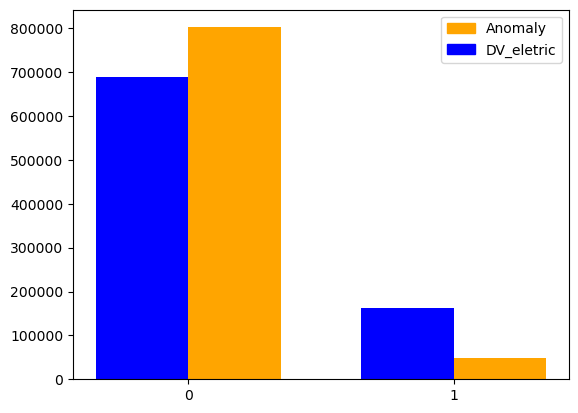

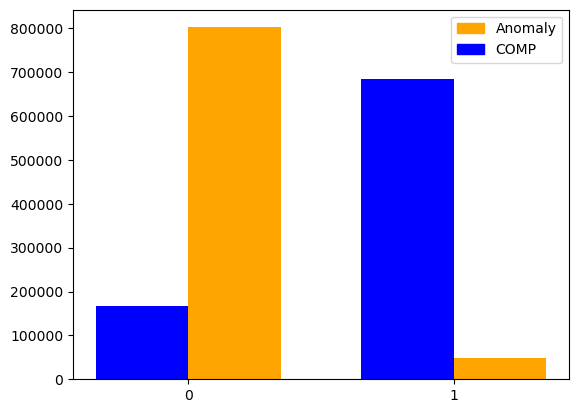

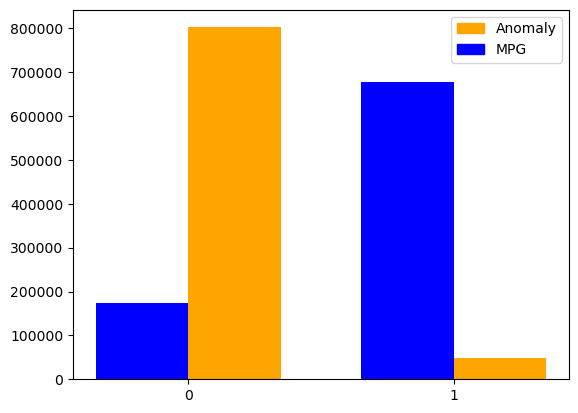

In [209]:
digital = ["DV_eletric", "COMP", "MPG"]

width = 0.35 

for col in digital:
    fig, ax = plt.subplots()
    x_labels = ['0', '1']
    
    x = np.arange(len(x_labels))
    ax.bar(x + width/2, np.bincount(dataset["anomaly"]), width, label='Anomaly', color=['orange'])
    ax.bar(x - width/2, np.bincount(dataset[col]), width, label='col', color=['blue'])
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    
    colors = { 'Anomaly':'orange', col:'blue' }         
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.legend(handles, labels)
    plt.show()


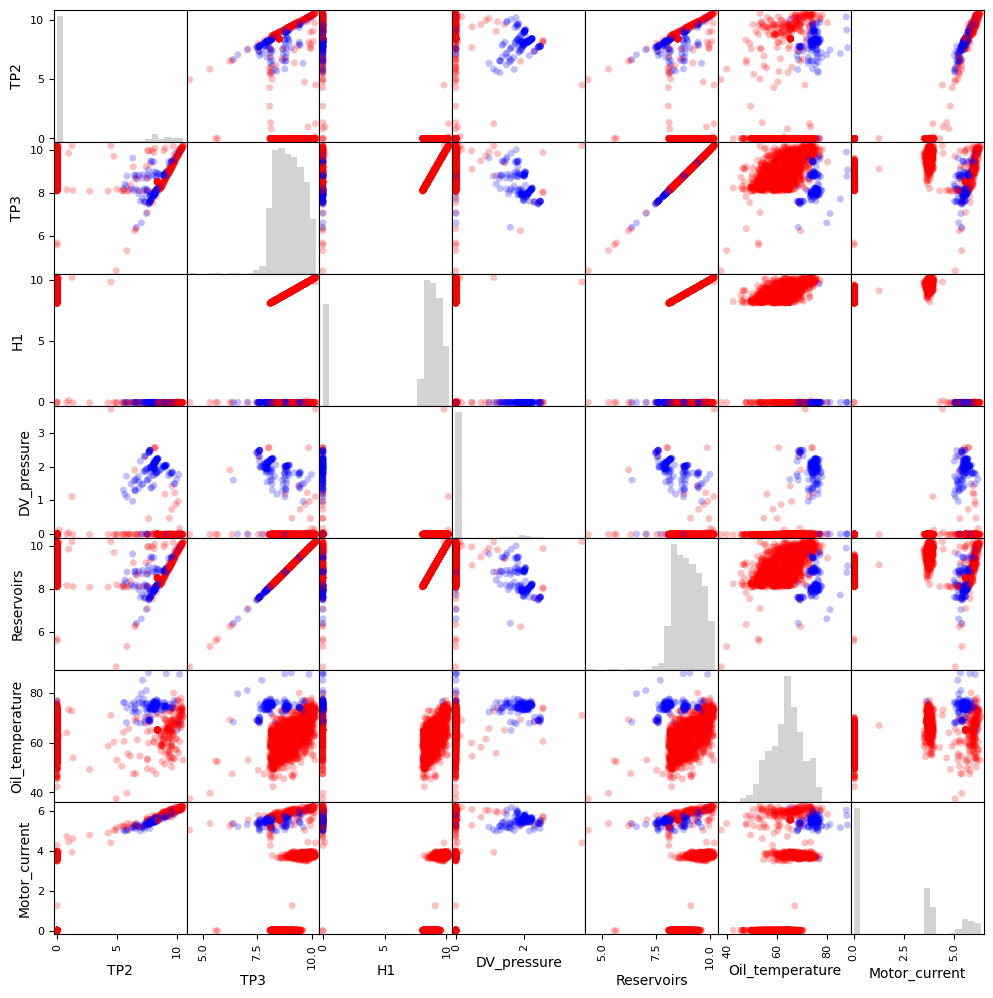

In [225]:
class_colors_map = {0:'#ff0000', 1:'#0000ff'}

sample = dataset.sample(2000)
_ = pd.plotting.scatter_matrix(sample.drop(["COMP", "DV_eletric", "Towers", "MPG", "LPS", "Pressure_switch", "Oil_level", "Caudal_impulses", "anomaly"], axis=1), 
                               c=sample["anomaly"].map(class_colors_map), 
                               alpha=0.25, 
                               figsize=(12,12), 
                               marker="o",
                               s=25,
                               hist_kwds={"bins": 20, "color": "lightgray"})


## Preparazione Dati
(Linee guida: Preparare i dati per l’addestramento e la validazione dei modelli di predizione: isolare la variabile “target”
da predire e le variabili predittive, suddividere i dati in training e test set, eseguire eventuali operazioni di
preprocessing come ad es. one-hot encoding di variabili categoriche e oversampling o undersampling in
caso di classi sbilanciate.)

In [97]:
all_features = {
    "TP2": dataset["TP2"],
    "TP3": dataset["TP3"],
    "H1": dataset["H1"],
    "DV_pressure": dataset["DV_pressure"],
    "Reservoirs": dataset["Reservoirs"],
    "Oil_temperature": dataset["Oil_temperature"],
    "Motor_current": dataset["Motor_current"],
    
    "COMP": dataset["COMP"].astype(np.uint8),
    "DV_eletric": dataset["DV_eletric"].astype(np.uint8),
    "Towers": dataset["Towers"].astype(np.uint8),
    "MPG": dataset["MPG"].astype(np.uint8),
    "LPS": dataset["LPS"].astype(np.uint8),
    "Pressure_switch": dataset["Pressure_switch"].astype(np.uint8),
    "Oil_level": dataset["Oil_level"].astype(np.uint8),
    "Caudal_impulses": dataset["Caudal_impulses"].astype(np.uint8),
}

analog_features = {
    "TP2": dataset["TP2"].shift(1),
    "TP3": dataset["TP3"].shift(1),
    "H1": dataset["H1"].shift(1),
    "DV_pressure": dataset["DV_pressure"].shift(1),
    "Reservoirs": dataset["Reservoirs"].shift(1),
    "Oil_temperature": dataset["Oil_temperature"].shift(1),
    "Motor_current": dataset["Motor_current"].shift(1),
    "TP2_lag": dataset["TP2"].shift(2),
    "TP3_lag": dataset["TP3"].shift(2),
    "H1_lag": dataset["H1"].shift(2),
    "DV_pressure_lag": dataset["DV_pressure"].shift(2),
    "Reservoirs_lag": dataset["Reservoirs"].shift(2),
    "Oil_temperature_lag": dataset["Oil_temperature"].shift(2),
    "Motor_current_lag": dataset["Motor_current"].shift(2),
    
}
X = pd.DataFrame(analog_features)[2:]

y = dataset["anomaly"].astype(np.uint8)[2:]

X.head(5)

,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,COMP_lag,DV_eletric_lag,Towers_lag,MPG_lag,LPS_lag,Pressure_switch_lag,Oil_level_lag,Caudal_impulses_lag
timestamp,,,,,,,,,,,,,,,,
2020-02-01 00:00:19,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:29,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:39,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:49,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:59,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [98]:
from sklearn.model_selection import train_test_split
period = X.index.month == 5
#period &= X.index.month <=6
X_train, X_val, y_train, y_val = train_test_split(
    X.loc[period],
    y.loc[period],
    test_size=1/3, random_state=42
)

X_train.index.isin(X_val.index).sum()

y_val.value_counts(normalize=True)

0    0.932825
1    0.067175
Name: anomaly, dtype: float64

## Addestramento e Validazione
(Linee guida: Addestrare e validare due o più modelli di predizione, calcolandone le misure di performance viste nel
corso (es. MSE, errore relativo e coefficiente R² per modelli di regressione) e analizzando il modello
addestrato (es. coefficienti in una regressione lineare o nodi dei primi livelli di un albero decisionale) per
individuare le variabili più o meno rilevanti nella predizione.)

In [86]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8849913720994143

In [87]:
model.predict(X_val)

array([ 0.07248543, -0.00329017,  0.01886986, ..., -0.00752491,
        0.01655524,  0.73064176])

In [88]:
#model.score(mired_X_val, mired_Y_val)
#model.predict(mired_X_val).mean()
from sklearn.metrics import classification_report
prediction = model.predict(X_val)
prediction = [0 if i<=0.5 else 1 for i in prediction]
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     66169
           1       0.93      0.98      0.95      4765

    accuracy                           0.99     70934
   macro avg       0.96      0.99      0.97     70934
weighted avg       0.99      0.99      0.99     70934



In [33]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X_train, y_train)
model.score(X_val, y_val)

C:\Users\nicco\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9941917839118053

In [36]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("poly",    PolynomialFeatures(degree=3, include_bias=False) ),
    ("regr", Ridge(alpha=1.0) )
])

model.fit(X_train, y_train)
model.score(X_val, y_val)

0.6487325634346177

In [39]:
from sklearn.metrics import classification_report
prediction = model.predict(X_val)
prediction = [0 if i<=0.5 else 1 for i in prediction]
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66169
           1       0.96      0.98      0.97      4765

    accuracy                           1.00     70934
   macro avg       0.98      0.99      0.98     70934
weighted avg       1.00      1.00      1.00     70934



In [40]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X_train, y_train)
print("Non Regolarizzato:",model.score(X_val,y_val))

# regolarizzato
model = LogisticRegression(solver="saga", random_state=42, penalty="l1", C=0.01)
model.fit(X_train, y_train);
print("Regolarizzato:",model.score(X_val,y_val))

#elasticnet
model = LogisticRegression(
    solver="saga", random_state=42,
    penalty="elasticnet", C=0.1, l1_ratio=0.2)
model.fit(X_train, y_train);
print("Elasticnet:",model.score(X_val,y_val))

C:\Users\nicco\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Non Regolarizzato: 0.9941917839118053


C:\Users\nicco\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Regolarizzato: 0.9942763695829926
Elasticnet: 0.9941917839118053


C:\Users\nicco\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [41]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train, y_train);
model.score(X_val,y_val)

0.9923590943694138

In [42]:
prediction = model.predict(X_val).astype(np.uint8)
print(classification_report(y_val, prediction))
#print(y_val.dtype, prediction.dtype)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     66169
           1       0.92      0.97      0.94      4765

    accuracy                           0.99     70934
   macro avg       0.96      0.98      0.97     70934
weighted avg       0.99      0.99      0.99     70934



In [99]:
import xgboost
from xgboost import XGBClassifier 
model = XGBClassifier(objective="reg:squarederror", learning_rate=0.0157, reg_lambda= 0.008, reg_alpha=0.0001, n_estimators=625) 
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9328248794654186

In [100]:
prediction = model.predict(X_val)
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97     66169
           1       0.00      0.00      0.00      4765

    accuracy                           0.93     70934
   macro avg       0.47      0.50      0.48     70934
weighted avg       0.87      0.93      0.90     70934



C:\Users\nicco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nicco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nicco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [103]:
failure_start_1 = (X.index > datetime.datetime(2020, 4, 12, 11, 49, 0)) & (X.index <= datetime.datetime(2020, 4, 12, 11, 51, 0))
failure_start_2 = (X.index > datetime.datetime(2020, 5, 18, 4, 59, 0)) & (X.index <= datetime.datetime(2020, 5, 18, 5, 1, 0))
y[failure_start_1]

timestamp
2020-04-12 11:49:02    0
2020-04-12 11:49:12    0
2020-04-12 11:49:22    0
2020-04-12 11:49:32    0
2020-04-12 11:49:42    0
2020-04-12 11:49:51    0
2020-04-12 11:50:01    1
2020-04-12 11:50:11    1
2020-04-12 11:50:21    1
2020-04-12 11:50:31    1
2020-04-12 11:50:41    1
2020-04-12 11:50:51    1
Name: anomaly, dtype: uint8

In [104]:
print(X[failure_start_1].index)
model.predict(X[failure_start_1])

DatetimeIndex(['2020-04-12 11:49:02', '2020-04-12 11:49:12',
               '2020-04-12 11:49:22', '2020-04-12 11:49:32',
               '2020-04-12 11:49:42', '2020-04-12 11:49:51',
               '2020-04-12 11:50:01', '2020-04-12 11:50:11',
               '2020-04-12 11:50:21', '2020-04-12 11:50:31',
               '2020-04-12 11:50:41', '2020-04-12 11:50:51'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Ricerca Iperparametri
(Linee guida: Scegliere uno o più modelli di base (es. regressione ridge) ed eseguire una ricerca degli iperparametri
esaustiva (grid search) o a campione (randomized search) che massimizzi le performance del modello.)